In [3]:
import math
import importlib
import tree_search
importlib.reload(tree_search)
from tree_search import DebateState, Judge, MCTS, MCTSRandom
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import random
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import multiprocessing

# Get the number of available CPU cores
num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

Number of CPU cores available: 16


In [39]:
class MaskAllButNPixels(object):
    def __init__(self, N):
        self.N = N

    def __call__(self, img):
        # Ensure img is a tensor and squeeze it
        if not isinstance(img, torch.Tensor):
            img = transforms.ToTensor()(img)
        img = img.squeeze()

        mask = torch.zeros_like(img)
        new_img = torch.zeros_like(img)

        non_zero_indices = torch.nonzero(img)
        if len(non_zero_indices) < self.N:
            return torch.stack([mask, img])

        random_indices = torch.randperm(len(non_zero_indices))[:self.N]
        rows, cols = non_zero_indices[random_indices].T

        mask[rows, cols] = 1
        new_img[rows, cols] = img[rows, cols]

        return torch.stack([mask, new_img])

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        # 1. Convolutional Layer #1: Applies 32 5x5 filters (extracting 5x5-pixel subregions), with ReLU activation function
        x = torch.relu(self.conv1(x))
        # 2. Pooling Layer #1: Performs max pooling with a 2x2 filter and stride of 2 (which specifies that pooled regions do not overlap)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # 3. Convolutional Layer #2: Applies 64 5x5 filters, with ReLU activation function
        x = torch.relu(self.conv2(x))
        # 4. Pooling Layer #2: Again, performs max pooling with a 2x2 filter and stride of 2
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 7 * 7)
        # 5. Dense Layer #1: 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 that any given element will be dropped during training)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        # 6. Dense Layer #2 (Logits Layer): 10 neurons, one for each digit target class (0–9).
        x = self.fc2(x)
        return x

In [41]:
def visualize_state(state, title="Current State"):
    """
    Visualize the current state by displaying the masked image and mask.

    Args:
        state (DebateState): The current game state.
        title (str): Title for the plot.
    """
    masked_image = (
        state.image * state.mask).squeeze().cpu().numpy()  # Masked image
    mask = state.mask.squeeze().cpu().numpy()  # Mask

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Display Mask
    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title('Mask')
    axes[0].axis('off')

    # Display Masked Image
    axes[1].imshow(masked_image, cmap='gray')
    axes[1].set_title('Masked Image')
    axes[1].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def play_game(model, test_dataset, index, num_pixels=6, num_rollouts=1000, visualize=False, random=False):
    """
    Play a single game of the debate game.

    Args:
        model (nn.Module): The trained Net model.
        test_dataset (Dataset): The MNIST test dataset.
        index (int): Index of the test image to use.
        num_pixels (int): Number of pixels to reveal.
        num_rollouts (int): Number of MCTS rollouts.
        visualize (bool): Whether to visualize each step.

    Returns:
        final_score (float): The final score from the judge.
        predicted_label (int): The label predicted by the model.
    """
    # Initialize Judge and MCTS
    judge = Judge(model)
    if random:
        mcts = MCTSRandom(judge=judge, num_rollouts=num_rollouts)
    else:
        mcts = MCTS(judge=judge, num_rollouts=num_rollouts)

    # Get the image and label
    image, label = test_dataset[index]
    image = image.to(device).squeeze()
    label = label
    # Initialize game state
    initial_state = DebateState(
        image=image, label=label, num_pixels_to_reveal=num_pixels)

    current_state = initial_state
    turn = 0

    while not current_state.is_terminal():
        # MCTS selects the best action
        mcts.search(current_state)  # Perform MCTS rollouts
        action = mcts.best_action(mcts.root)  # Retrieve the best action

        if action is None:
            print("No valid actions available. Ending game.")
            break

        # Apply the action
        try:
            current_state = current_state.apply_action(action)
            # print(f"Player {turn + 1} revealed pixel at index {action}")
        except ValueError as e:
            print(f"Invalid action: {e}")
            break

        turn += 1

    # Final evaluation
    final_score = judge.evaluate(current_state)
    # Get the predicted label with highest probability
    predicted_label = judge.predict(current_state)

    return final_score, predicted_label

In [42]:
# import multiprocessing
# import concurrent.futures
# import time
# from tqdm import tqdm

# def play_game_wrapper(args):
#     return play_game(*args)

# def play_game_batch(batch_args):
#     return [play_game(*args) for args in batch_args]

# # Initialize the model and load weights
# model = Net().to(device)
# model.load_state_dict(torch.load('mnist_judge_6pixels.pth', map_location=device))
# model.eval()

# # Load the MNIST test dataset
# test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# # Define hyperparameters
# num_pixels = 6
# num_rollouts = 10
# num_images_to_use = 10  # Adjust as needed

# # Prepare arguments for each game
# args_list = [(model, test_dataset, i, num_pixels, num_rollouts, False, False) 
#              for i in range(num_images_to_use)]

# # With concurrent.futures
# start_time = time.time()
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     results_multi = list(tqdm(executor.map(play_game_wrapper, args_list), 
#                               total=num_images_to_use, 
#                               desc="Processing Images (concurrent.futures)"))
# multi_process_time = time.time() - start_time
# print(f"concurrent.futures time: {multi_process_time:.2f} seconds")

# # With batch processing
# start_time = time.time()
# batch_size = 2  # Adjust this value
# batched_args = [args_list[i:i+batch_size] for i in range(0, len(args_list), batch_size)]
# num_cores = multiprocessing.cpu_count()
# with multiprocessing.Pool(processes=num_cores) as pool:
#     results_multi = list(tqdm(pool.imap(play_game_batch, batched_args), 
#                               total=len(batched_args), 
#                               desc="Processing Batches (Multiprocessing)"))
# results_multi = [item for sublist in results_multi for item in sublist]  # Flatten the results
# multi_process_time = time.time() - start_time
# print(f"Batch processing time: {multi_process_time:.2f} seconds")

# # Without multiprocessing
# start_time = time.time()
# results_single = []
# for args in tqdm(args_list, desc="Processing Images (Single Process)"):
#     results_single.append(play_game_wrapper(args))
# single_process_time = time.time() - start_time
# print(f"Single process time: {single_process_time:.2f} seconds")

# # With multiprocessing
# start_time = time.time()
# num_cores = multiprocessing.cpu_count()
# with multiprocessing.Pool(processes=num_cores) as pool:
#     results_multi = list(tqdm(pool.imap(play_game_wrapper, args_list), 
#                               total=num_images_to_use, 
#                               desc="Processing Images (Multiprocessing)"))
# multi_process_time = time.time() - start_time
# print(f"Multi-process time: {multi_process_time:.2f} seconds")

# # Calculate speedup
# speedup = single_process_time / multi_process_time
# print(f"Speedup: {speedup:.2f}x")

# # Process results (you can use either results_single or results_multi here)
# error_matrix_debate = torch.zeros(10, 10)
# total_per_class_debate = torch.zeros(10)

# for i, (final_score, predicted_label) in enumerate(results_multi):
#     true_label = test_dataset[i][1]
#     if predicted_label != true_label:
#         error_matrix_debate[true_label, predicted_label] += 1
#     total_per_class_debate[true_label] += 1

# print("Debate Game Evaluation Completed.")

# # Continue with your error matrix visualization code...

In [43]:
30302135

30302135

In [44]:
print(len(test_dataset))

10000


In [49]:
import cProfile
import time
from tqdm import tqdm  # Import tqdm for progress bar
from IPython.display import clear_output

# Initialize the model and load weights
model = Net().to(device)
model.load_state_dict(torch.load(
    'mnist_judge_6pixels.pth', map_location=device))
model.eval()
torch.set_grad_enabled(False)
model = torch.jit.script(model)


# Load the MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Define hyperparameters
num_pixels = 6
num_rollouts = 1000
num_images_to_use = 100  # Use all images from the test dataset

# Create error matrix
error_matrix_debate = torch.zeros(10, 10)
total_per_class_debate = torch.zeros(10)
correct_predictions = 0  # Initialize correct predictions counter

profile = False
start_time = time.time()  # Start time for the loop

# Use tqdm to create a progress bar
pbar = tqdm(range(num_images_to_use), desc="Processing Images")
for index in pbar:
    # Profile the play_game function call
    if profile:
        pr = cProfile.Profile()
        pr.enable()
    
    final_score, predicted_label = play_game(
        model=model,
        test_dataset=test_dataset,
        index=index,
        num_pixels=num_pixels,
        num_rollouts=num_rollouts,
        visualize=False,  # Set to True if you want to visualize each game
        random=False
    )
    
    if profile:
        pr.disable()
        pr.print_stats(sort='cumulative')

    image, true_label = test_dataset[index]
    image = image.to(device).squeeze()

    # Get the true label
    true_label = true_label

    # Get the predicted label based on the final_score using the new predicted_label
    pred_label = predicted_label  # Directly use the predicted label from play_game

    # Update error matrix
    if pred_label != true_label:
        error_matrix_debate[true_label, pred_label] += 1
    else:
        correct_predictions += 1  # Increment correct predictions counter
    total_per_class_debate[true_label] += 1

    # Calculate and display the win rate
    win_rate = correct_predictions / (index + 1) * 100
    pbar.set_postfix({'Win Rate': f'{win_rate:.2f}%'})

print("Debate Game Evaluation Completed.")

Processing Images:  25%|██▌       | 25/100 [12:10<36:30, 29.20s/it, Win Rate=68.00%]


: 

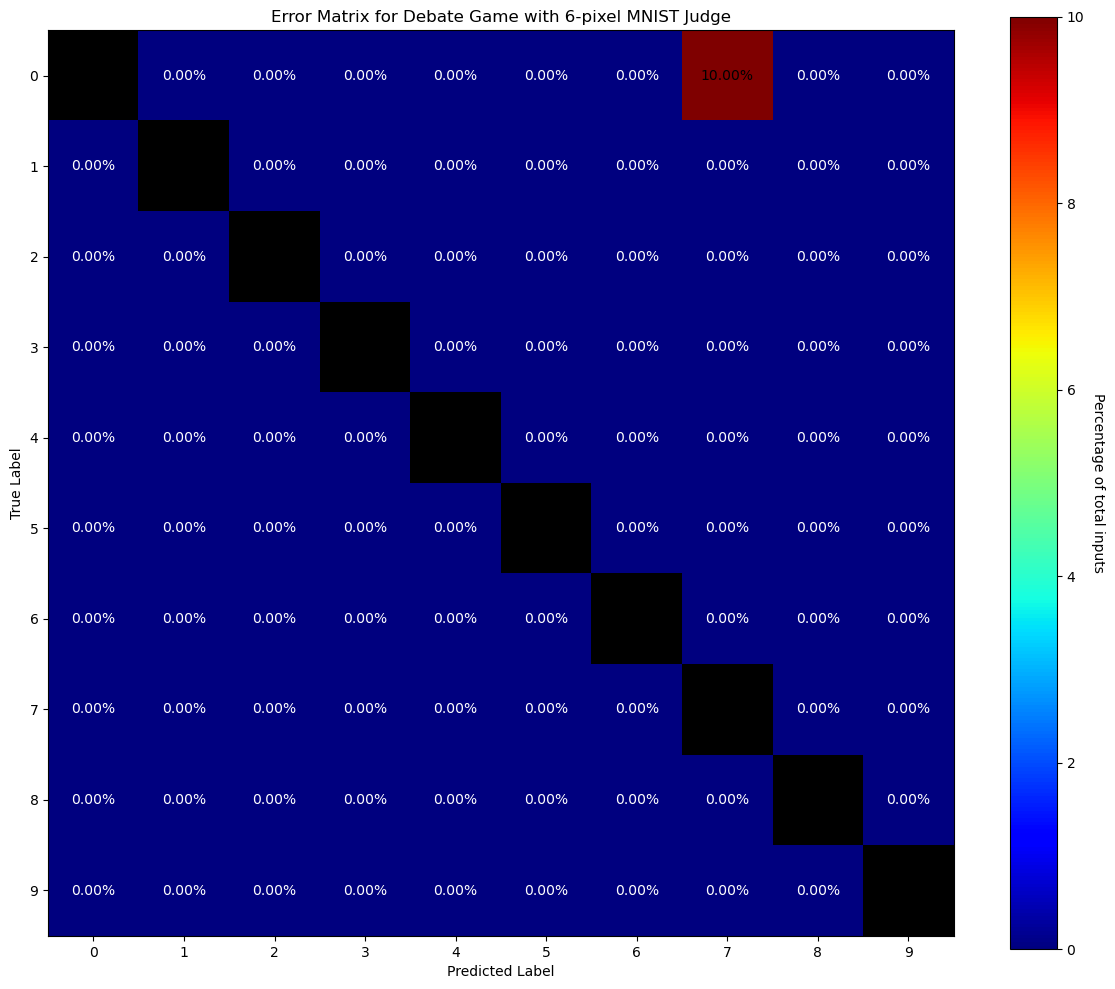

In [25]:
total_inputs = num_images_to_use 
# Save the error matrix to a .npz file
#np.savez('error_matrix_debate.npz', error_matrix_debate.numpy())



# Convert to percentages of total inputs
error_matrix_percent_debate = error_matrix_debate / total_inputs * 100

# Create heatmap
plt.figure(figsize=(12, 10))
cmap = plt.cm.jet
cmap.set_bad('black')  # Set the color for masked values to black

masked_error_matrix_debate = np.ma.array(
    error_matrix_percent_debate.numpy(), mask=np.eye(10))  # Mask diagonal
im = plt.imshow(masked_error_matrix_debate, cmap=cmap,)# vmin=0, vmax=2)

# Create colorbar
cbar = plt.colorbar(im)
cbar.set_label('Percentage of total inputs', rotation=270, labelpad=15)

# Add text annotations
for i in range(10):
    for j in range(10):
        if i != j:  # Skip diagonal elements
            text = plt.text(j, i, f'{error_matrix_percent_debate[i, j]:.2f}%',
                            ha="center", va="center",
                            color="white" if error_matrix_percent_debate[i, j] < 1 else "black")

plt.title(f'Error Matrix for Debate Game with {num_pixels}-pixel MNIST Judge')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()

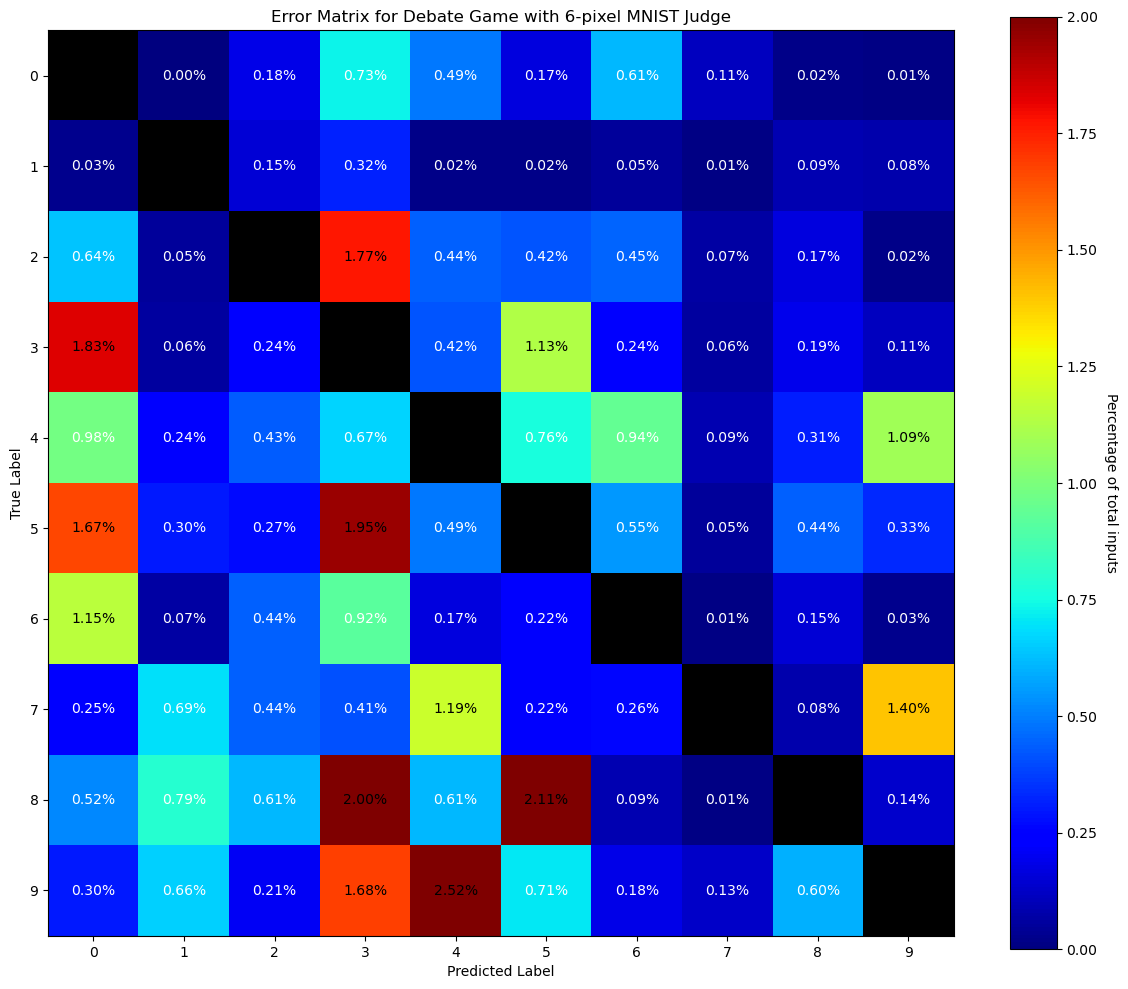

In [13]:
total_inputs = len(test_dataset)
# Save the error matrix to a .npz file
#np.savez('error_matrix_debate.npz', error_matrix_debate.numpy())



# Convert to percentages of total inputs
error_matrix_percent_debate = error_matrix_debate / total_inputs * 100

# Create heatmap
plt.figure(figsize=(12, 10))
cmap = plt.cm.jet
cmap.set_bad('black')  # Set the color for masked values to black

masked_error_matrix_debate = np.ma.array(
    error_matrix_percent_debate.numpy(), mask=np.eye(10))  # Mask diagonal
im = plt.imshow(masked_error_matrix_debate, cmap=cmap, vmin=0, vmax=2)

# Create colorbar
cbar = plt.colorbar(im)
cbar.set_label('Percentage of total inputs', rotation=270, labelpad=15)

# Add text annotations
for i in range(10):
    for j in range(10):
        if i != j:  # Skip diagonal elements
            text = plt.text(j, i, f'{error_matrix_percent_debate[i, j]:.2f}%',
                            ha="center", va="center",
                            color="white" if error_matrix_percent_debate[i, j] < 1 else "black")

plt.title(f'Error Matrix for Debate Game with {num_pixels}-pixel MNIST Judge')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()

Processing Images:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Images: 100%|██████████| 10000/10000 [00:37<00:00, 268.08it/s]


Debate Game Evaluation Completed.


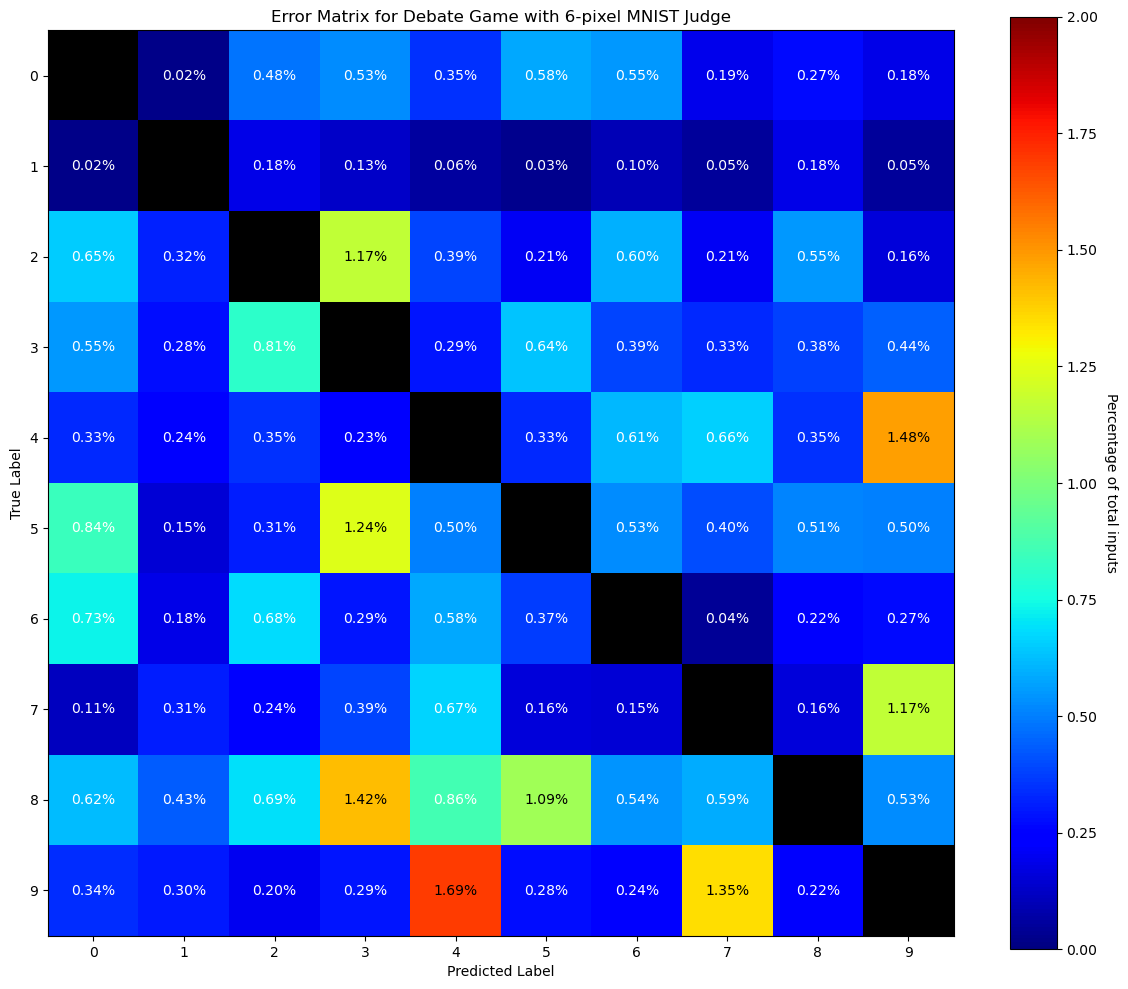

In [16]:
def play_random_game(model, test_dataset, index, num_pixels=6):
    image, label = test_dataset[index]
    image = image.to(device).squeeze()
    state = DebateState(image=image, label=label, num_pixels_to_reveal=num_pixels)
    
    while not state.is_terminal():
        action = random.choice(state.get_legal_actions())
        state = state.apply_action(action)
    
    judge = Judge(model)
    final_score = judge.evaluate(state)
    predicted_label = judge.predict(state)
    
    return final_score, predicted_label

import cProfile
import time
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the model and load weights
model = Net().to(device)
model.load_state_dict(torch.load(
    'mnist_judge_6pixels.pth', map_location=device))
model.eval()

# Load the MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Define hyperparameters
num_pixels = 6
num_images_to_use = len(test_dataset)  # Use all images from the test dataset

# Create error matrix
error_matrix_debate = torch.zeros(10, 10)
total_per_class_debate = torch.zeros(10)

profile = False
start_time = time.time()  # Start time for the loop

# Use tqdm to create a progress bar
for index in tqdm(range(num_images_to_use), desc="Processing Images"):
    # Profile the play_game function call
    if profile:
        pr = cProfile.Profile()
        pr.enable()
    
    final_score, predicted_label = play_random_game(
        model=model,
        test_dataset=test_dataset,
        index=index,
        num_pixels=num_pixels,
    )
    
    if profile:
        pr.disable()
        pr.print_stats(sort='cumulative')

    image, true_label = test_dataset[index]
    image = image.to(device).squeeze()

    # Get the true label
    true_label = true_label

    # Get the predicted label based on the final_score using the new predicted_label
    pred_label = predicted_label  # Directly use the predicted label from play_game

    # Update error matrix
    if pred_label != true_label:
        error_matrix_debate[true_label, pred_label] += 1
    total_per_class_debate[true_label] += 1

print("Debate Game Evaluation Completed.")

total_inputs = len(test_dataset)

# Convert to percentages of total inputs
error_matrix_percent_debate = error_matrix_debate / total_inputs * 100

# Create heatmap
plt.figure(figsize=(12, 10))
cmap = plt.cm.jet
cmap.set_bad('black')  # Set the color for masked values to black

masked_error_matrix_debate = np.ma.array(
    error_matrix_percent_debate.numpy(), mask=np.eye(10))  # Mask diagonal
im = plt.imshow(masked_error_matrix_debate, cmap=cmap, vmin=0, vmax=2)

# Create colorbar
cbar = plt.colorbar(im)
cbar.set_label('Percentage of total inputs', rotation=270, labelpad=15)

# Add text annotations
for i in range(10):
    for j in range(10):
        if i != j:  # Skip diagonal elements
            text = plt.text(j, i, f'{error_matrix_percent_debate[i, j]:.2f}%',
                            ha="center", va="center",
                            color="white" if error_matrix_percent_debate[i, j] < 1 else "black")

plt.title(f'Error Matrix for Debate Game with {num_pixels}-pixel MNIST Judge')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()

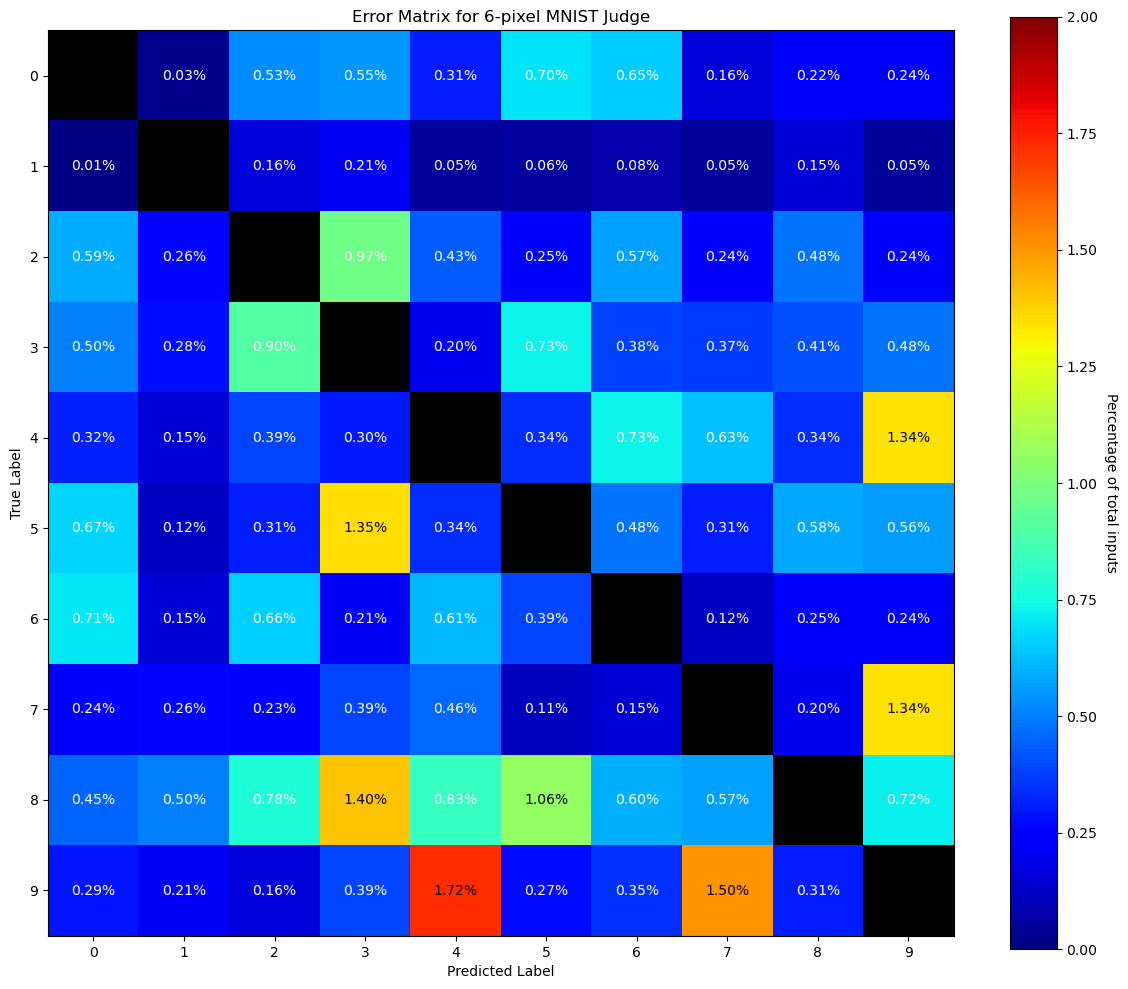

In [ ]:
# Define hyperparameters
learning_rate = 1e-4
batch_size = 128
num_epochs = 64  # 60,000 samples / 128 ~ 469 batches per epoch * 64 epocs = 30,016

# Set number of pixels
num_pixels = 6  # Change to 4 for the 4-pixel version

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    MaskAllButNPixels(num_pixels)
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create error matrix
error_matrix = torch.zeros(10, 10)
total_per_class = torch.zeros(10)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            if t != p:  # Only count errors
                error_matrix[t.long(), p.long()] += 1
            total_per_class[t.long()] += 1

# Convert to percentages of total inputs
error_matrix_percent = error_matrix / len(test_dataset) * 100

# Create heatmap
plt.figure(figsize=(12, 10))
cmap = plt.cm.jet
cmap.set_bad('black')  # Set the color for masked values to black

masked_error_matrix = np.ma.array(
    error_matrix_percent.numpy(), mask=np.eye(10))  # Mask diagonal
im = plt.imshow(masked_error_matrix, cmap=cmap, vmin=0, vmax=2)

# Create colorbar
cbar = plt.colorbar(im)
cbar.set_label('Percentage of total inputs', rotation=270, labelpad=15)

# Add text annotations
for i in range(10):
    for j in range(10):
        if i != j:  # Skip diagonal elements
            text = plt.text(j, i, f'{error_matrix_percent[i, j]:.2f}%',
                            ha="center", va="center", color="white" if error_matrix_percent[i, j] < 1 else "black")

plt.title(f'Error Matrix for {num_pixels}-pixel MNIST Judge')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()